<a href="https://colab.research.google.com/github/Dhanasree-Rajamani/Deep_Learning_Assignments/blob/main/Assignment_7/Efficient_net_and_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
dataset_size

3670

In [ ]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
n_classes

5

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

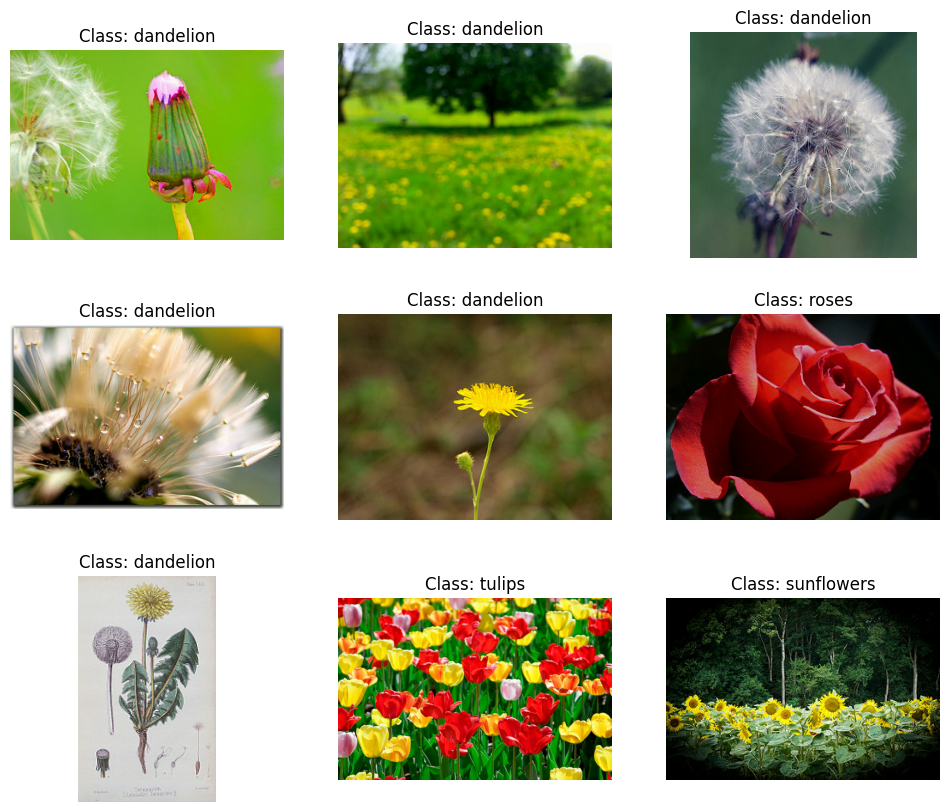

In [ ]:
# extra code – displays the first 9 images in the validation set

plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

In [ ]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

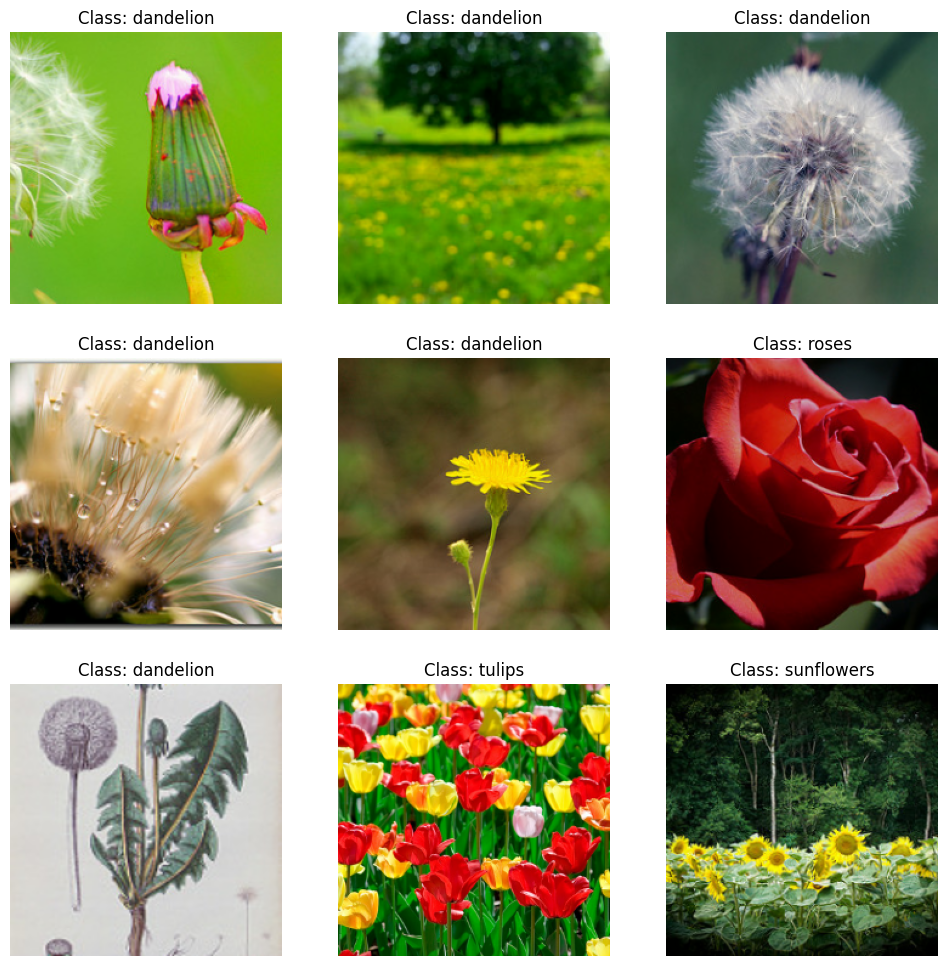

In [ ]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

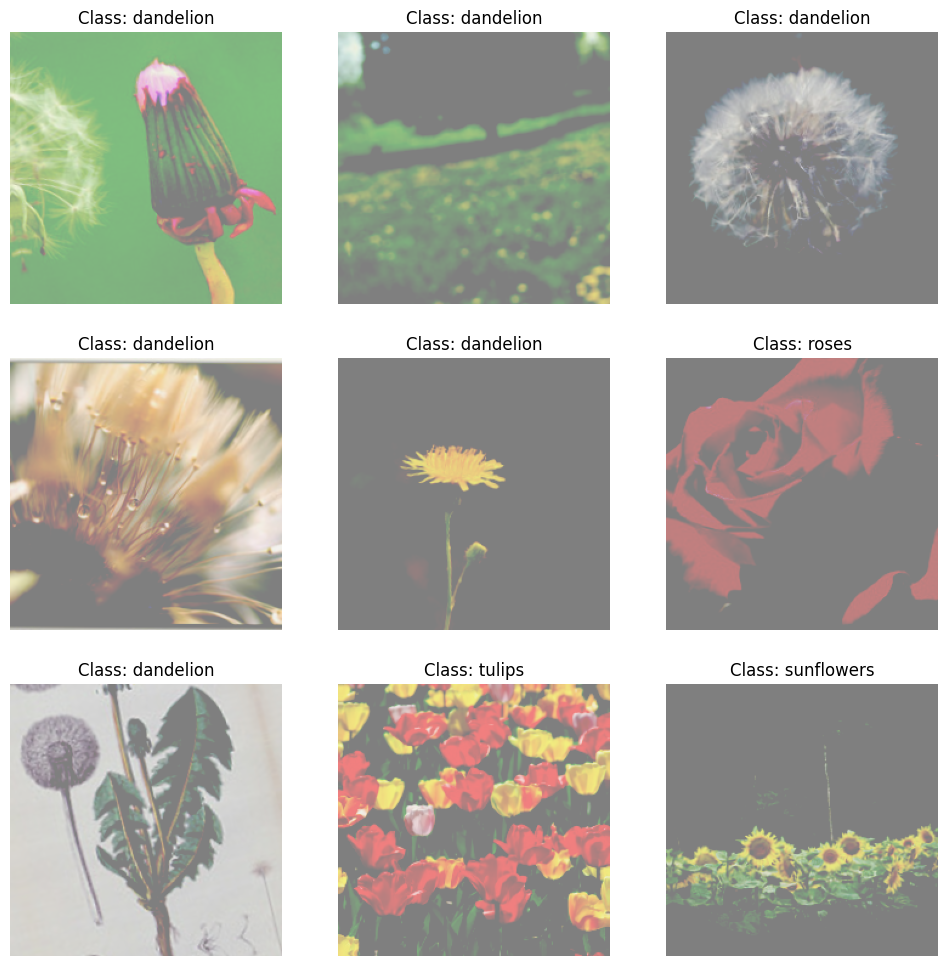

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 705s 8s/step - loss: 0.7405 - accuracy: 0.8096 - val_loss: 0.6661 - val_accuracy: 0.8385
Epoch 2/3
86/86 [==============================] - 684s 8s/step - loss: 0.3121 - accuracy: 0.9124 - val_loss: 0.5176 - val_accuracy: 0.8711
Epoch 3/3
86/86 [==============================] - 664s 8s/step - loss: 0.2046 - accuracy: 0.9360 - val_loss: 0.5308 - val_accuracy: 0.8748


In [ ]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=1)

Epoch 1/10
13/86 [===>..........................] - ETA: 17:49 - loss: 0.3904 - accuracy: 0.8606

Classfication and Localization

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  
              optimizer=optimizer, metrics=["accuracy"])


In [ ]:
# extra code – fits the model using random target bounding boxes (in real life
#              you would need to create proper targets instead)

def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Precision/Recall

In [ ]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))
recalls = np.linspace(0, 1, 11)

In [ ]:
precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center")
plt.show()